---
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Cátedra de Investigación Operativa__\
__Autor: Rodrigo Maranzana__, Rmaranzana@frba.utn.edu.ar

---

# Ejemplo de optimizacion de Floor plan

En este ejemplo aplicamos la librería CVXPY de Python para resolver el caso de floorplanning cuadrático.

Link a libería: https://github.com/cvxpy/cvxpy

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as pac
import cvxpy as cp
import numpy as np

(CVXPY) Sep 16 06:00:00 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 16 06:00:00 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


Cargamos parámetros y variables

In [44]:
# Parametros
rho = 2.5 # Espacio entre cajas
gamma_max = 5 # Aspect ratio superior
gamma_min = 1/5 # Aspect ratio inferior
Amin = np.array([350., 300., 200., 300., 300.])

# Variables
W = cp.Variable(shape=(1)) # Ancho 
H = cp.Variable(shape=(1)) # Largo
x = cp.Variable(shape=(5)) # Posición x del vértice inferior izquierdo
y = cp.Variable(shape=(5)) # Posición y del vértice inferior izquierdo
w = cp.Variable(shape=(5)) # Ancho de la caja
h = cp.Variable(shape=(5)) # Largo de la caja

Cargamos función objetivo y restricciones

In [84]:
# Indicamos la función objetivo:
objective = cp.Minimize(H + W) # Minimizar perímetro total

# Indicamos las restricciones:
## Restricciones de dependencia entre cajas en x:
constraints = [
    x[0] + w[0] + rho <= x[4],
    x[1] + w[1] + rho <= x[3],
    x[2] + w[2] + rho <= x[3],
    x[3] + w[3] + rho <= x[4],
    x[4] + w[4]       <= W
]

## Restricciones de dependencia entre cajas de y:
constraints += [
    y[2] + h[2] + rho <= y[1],
    y[1] + h[1] + rho <= y[0],
    y[3] + h[3] + rho <= y[0],
    y[0] + h[0] <= H,
    y[4] + h[4] <= H
]

# Restricción de área mínima para cada caja:
constraints.append(cp.log(Amin) <= cp.log(w) + cp.log(h)) # multiplicacion elemento por elemento
    
# Restricción de aspect ratio:
constraints.append(h <= cp.multiply(gamma_max, w))
constraints.append(h >= cp.multiply(gamma_min, w))
    
# Restricciones de positividad:
constraints += [
    W >= 0,
    H >= 0,
    x >= 0,
    y >= 0,
    w >= 0,
    h >= 0,
]

Creamos el problema de optimización y resolvemos

In [85]:
# Armamos el problema:
prob = cp.Problem(objective, constraints)

# Resolvemos
result = prob.solve()

# Obtenemos los valores optimos de perímetro y área:
print('Perímetro', 2 * prob.value)
print('Área', H.value[0] * W.value[0])

Perímetro 167.96304033112176
Área 1752.5903264450687


## Visualización

Utilizamos la librería Matplotlib para visualizar el resultado.

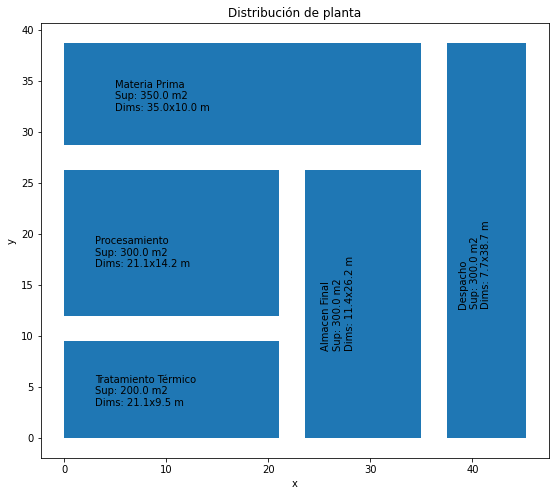

In [76]:
# Ploteamos la solución:
def texto(rotate):
    plt.text(xi+wi/7, yi+hi/3, f"{str(i)}\nSup: {round(wi*hi, 0)} m2\
                \nDims: {round(wi, 1)}x{round(hi, 1)} m", rotation=rotate)

plt.subplots(figsize=(12, 8))

areas = ["Materia Prima", "Procesamiento", "Tratamiento Térmico", "Almacen Final", "Despacho"]
for i, xi, yi, wi, hi in zip(areas, x.value, y.value, w.value, h.value):
    rectangle = pac.Rectangle((xi, yi), wi, hi)
    plt.gca().add_patch(rectangle)
    texto(0) if wi > hi else texto(90)
    
plt.axis('scaled')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distribución de planta")
plt.show()

In [72]:
x.value

array([4.11247048e-07, 2.45240181e-07, 3.67542649e-07, 2.35690696e+01,
       3.75057139e+01])